## Aim
* Given a stereo output directory, evaluate how the completeness and accuracy of products
* We aim to use consistent framework to evaluate the outputs from different stereo correlators
* Our end goal for the project is to ensure that the quality of GPU stereo correlator outputs is as good as their CPU counterparts

### Some potential metrics we are going to compute

* Disparity Completeness 
* Vertical elevation residual from LiDAR, with respect to slope, landcover classes
* time taken to complete the processing with difference correlation strategies
* CPU/GPU/memory load distribution
* Consistent parameters for all the implementations for a particular algorithm kernel combination output for best accuracy
* DEM stereo parameters used to be written in a dataframe which is easily digestible (maybe submit to ASP plot once complete?)


#### Disparity completeness
* Read the filtered disparity map, compute the valid pixels from the good-pixel map?

In [1]:
%cd /panfs/ccds02/nobackup/people/sbhusha1/ostfl/maxar/WV02WV02_20091222_10300100023BC100_1030010003D22F00/opencv_bm/

/panfs/ccds02/nobackup/people/sbhusha1/ostfl/maxar/WV02WV02_20091222_10300100023BC100_1030010003D22F00/opencv_bm


In [76]:
import os,glob
import shapely
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import box
import requests
from scipy import stats
import rasterio
import rioxarray 
from pyproj import CRS
import geopandas as gpd
import numpy as np

import pystac_client
import odc.stac

In [21]:
def calc_valdispperc(dem_dir):
    '''
    Given an output DEM directory, locate filtered disparity file (-F.tif) and rectified left image file (-L.tif) 
    to calculate aggregate percent valid disparity
    '''
    print(f'............. Working on {dem_dir} .............')
    print(f'Reading in filtered disparity map')
    # read in filtered disparity points F.tif (outliers have been removed)
    filtered_disp_fn = glob.glob(os.path.join(dem_dir, '*-F.tif'))[0]
    filtered_disparity = rioxarray.open_rasterio(filtered_disp_fn,masked=True).isel(band=0)
    valid_non_zero_disparity = np.count_nonzero(filtered_disparity)
    
    print(f'Reading in rectified left input image')    
    # read in original input points L.tif
    left_img_fn = glob.glob(os.path.join(dem_dir, '*-L.tif'))[0]
    l_img = rioxarray.open_rasterio(left_img_fn,masked=True).isel(band=0)
    left_img_count = l_img.count()
    print(f'Calculating percent valid disparity')        
    # calculate valid disparity
    val_disp_perc = (valid_non_zero_disparity/left_img_count)*100
    print(f'{val_disp_perc:0.2f}')
    return val_disp_perc

In [22]:
%%time 
calc_valdispperc('.')

............. Working on . .............
Reading in filtered disparity map


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Reading in rectified left input image


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Calculating percent valid disparity
83.96
CPU times: user 3min 27s, sys: 33.2 s, total: 4min
Wall time: 4min 1s


<xarray.DataArray ()> Size: 8B
array(83.96050797)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [23]:
%%time 
calc_valdispperc('../cpu/opencv_sgbm/')

............. Working on ../cpu/opencv_sgbm/ .............
Reading in filtered disparity map


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Reading in rectified left input image


/home/sbhusha1/.conda/envs/bhushan_gdal3/lib/python3.13/site-packages/rioxarray/_io.py:1143: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


Calculating percent valid disparity
97.72
CPU times: user 3min 32s, sys: 33.1 s, total: 4min 5s
Wall time: 4min 10s


<xarray.DataArray ()> Size: 8B
array(97.72427975)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

## Vertical elevation difference from LiDAR

In [30]:
%%time
reference_lidar_fn = '/panfs/ccds02/nobackup/people/sbhusha1/ostfl/maxar/lidar/atlanta_mvs_all_project-DSM_mos.tif'
opencv_bm_dsm_fn = 'opencv_bm_processing-DEM.tif'
opencv_sgm_dsm_fn = '../cpu/opencv_sgbm/opencv_sgbm_processing-DEM.tif'
opencv_bm_dsm = rioxarray.open_rasterio(opencv_bm_dsm_fn,masked=True).isel(band=0)
opencv_sgm_dsm = rioxarray.open_rasterio(opencv_sgm_dsm_fn,masked=True).isel(band=0).rio.reproject_match(opencv_bm_dsm,
                                                                                             resampling=rasterio.enums.Resampling.bilinear)
lidar_reference = rioxarray.open_rasterio(reference_lidar_fn,masked=True).isel(band=0).rio.reproject_match(opencv_bm_dsm,
                                                                                             resampling=rasterio.enums.Resampling.bilinear)

CPU times: user 57.5 s, sys: 11.2 s, total: 1min 8s
Wall time: 1min 8s


In [31]:
%%time
opencv_bm_residual = opencv_bm_dsm - lidar_reference
opencv_sgm_residual = opencv_sgm_dsm - lidar_reference

CPU times: user 877 ms, sys: 57.8 ms, total: 935 ms
Wall time: 937 ms


CPU times: user 8.9 s, sys: 611 ms, total: 9.51 s
Wall time: 9.53 s


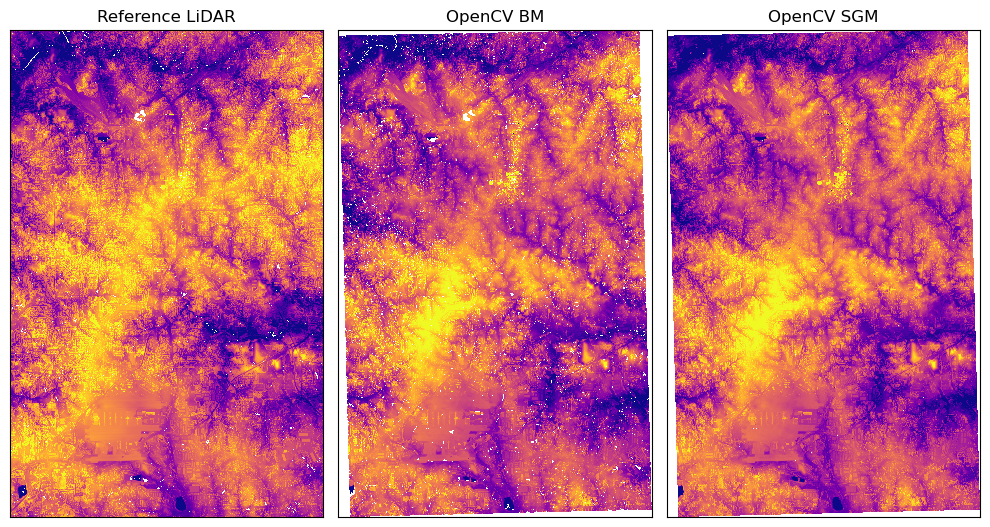

In [38]:
%%time
title_list = ['Reference LiDAR', 'OpenCV BM', 'OpenCV SGM']
cmin = np.nanpercentile(lidar_reference.to_numpy(),2)
cmax = np.nanpercentile(lidar_reference.to_numpy(),98)
f,ax = plt.subplots(1,3,figsize=(10,10))
lidar_reference.plot(ax=ax[0],cmap='plasma',vmin=cmin,vmax=cmax,add_colorbar=False)
opencv_bm_dsm.plot(ax=ax[1],cmap='plasma',vmin=cmin,vmax=cmax,add_colorbar=False)
opencv_sgm_dsm.plot(ax=ax[2],cmap='plasma',vmin=cmin,vmax=cmax,add_colorbar=False)

for idx,axa in enumerate(ax.ravel()):
    axa.set_title(title_list[idx])
    axa.set_aspect('equal')
    axa.set_xticks([])
    axa.set_yticks([])
    axa.set_xlabel('')
    axa.set_ylabel('')
plt.tight_layout()

In [49]:
def compute_med_nmad(da):
    med = da.median().values
    da_ar = da.to_numpy()
    da_non_nan = da_ar[~np.isnan(da_ar)]
    nmad = 1.4826*stats.median_abs_deviation(da_non_nan)
    return med,nmad

CPU times: user 7.13 s, sys: 463 ms, total: 7.59 s
Wall time: 7.61 s


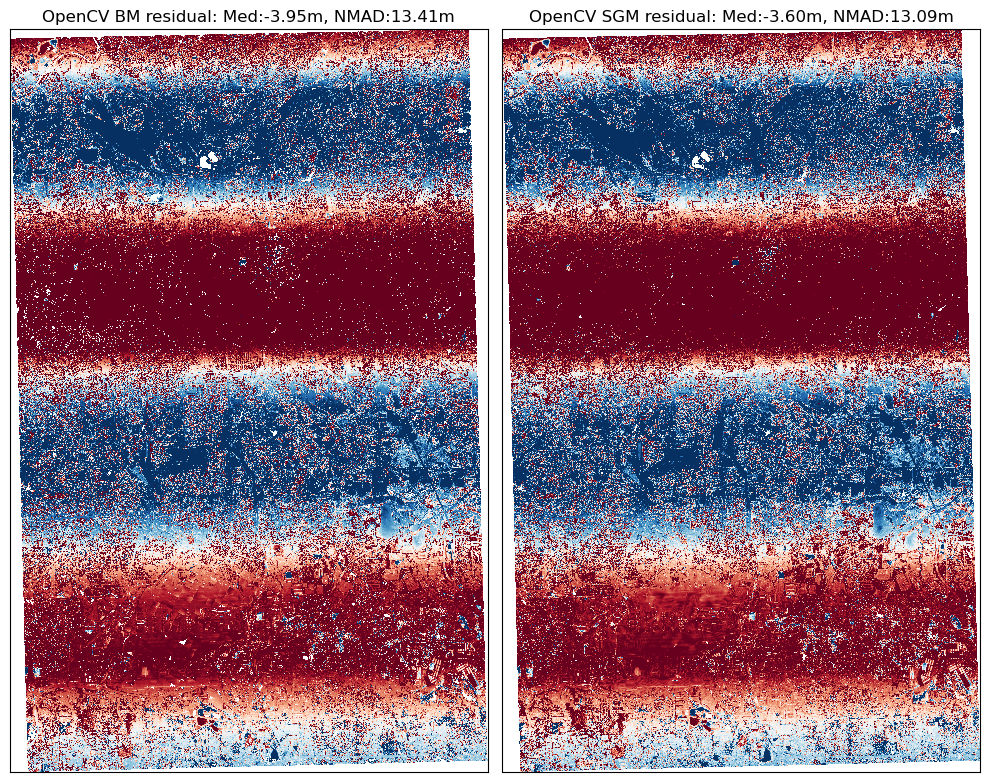

In [55]:
%%time
diff_clim = (-10,10)
f,ax = plt.subplots(1,2,figsize=(10,10))
med,nmad = compute_med_nmad(opencv_bm_residual)
title1 = f'OpenCV BM residual: Med:{med:.2f}m, NMAD:{nmad:.2f}m'
opencv_bm_residual.plot(ax=ax[0],cmap='RdBu',vmin=diff_clim[0],vmax=diff_clim[1],add_colorbar=False)
med,nmad = compute_med_nmad(opencv_sgm_residual)
title2 = f'OpenCV SGM residual: Med:{med:.2f}m, NMAD:{nmad:.2f}m'
opencv_sgm_residual.plot(ax=ax[1],cmap='RdBu',vmin=diff_clim[0],vmax=diff_clim[1],add_colorbar=False)
title_list = [title1,title2]
for idx,axa in enumerate(ax.ravel()):
    axa.set_title(title_list[idx])
    axa.set_aspect('equal')
    axa.set_xticks([])
    axa.set_yticks([])
    axa.set_xlabel('')
    axa.set_ylabel('')
plt.tight_layout()

### Add Worldcover based statistics

In [66]:
def get_esa_worldcover(
    bbox_input: gpd.GeoDataFrame
    | tuple
    | shapely.geometry.base.BaseGeometry
    | None = None,
    version: str = "v200",
    mask_nodata: bool = False,
) -> xr.DataArray:
    """
    Adapted from easysnowdata.remote_sensing.get_esa_worldcover (MIT license)
    Author: Eric Gagliano https://github.com/egagli/easysnowdata/blob/main/easysnowdata/remote_sensing.py
    Fetches 10m ESA WorldCover global land cover data (2020 v100 or 2021 v200) for a given bounding box.

    Description:
    The discrete classification maps provide 11 classes defined using the Land Cover Classification System (LCCS)
    developed by the United Nations (UN) Food and Agriculture Organization (FAO).

    Parameters
    ----------
    bbox_input
        GeoDataFrame containing the bounding box, or a tuple of (xmin, ymin, xmax, ymax), or a Shapely geometry.
    version
        Version of the WorldCover data. The two versions are v100 (2020) and v200 (2021). Default is 'v200'.
    mask_nodata
        Whether to mask no data values. Default is False.
        If False: (dtype=uint8, rio.nodata=0, rio.encoded_nodata=None)
        If True: (dtype=float32, rio.nodata=nan, rio.encoded_nodata=0)

    Returns
    -------
    worldcover_da
        WorldCover DataArray with class information in attributes.

    Examples
    --------
    >>> import geopandas as gpd
    >>> import easysnowdata
    >>>
    >>> # Define a bounding box for Mount Rainier
    >>> bbox = (-121.94, 46.72, -121.54, 46.99)
    >>>
    >>> # Fetch WorldCover data for the area
    >>> worldcover_da = easysnowdata.remote_sensing.get_esa_worldcover(bbox)
    >>>
    >>> # Plot the data using the example plot function
    >>> f, ax = worldcover_da.attrs['example_plot'](worldcover_da)

    Notes
    -----
    Data citation:
    Zanaga, D., Van De Kerchove, R., De Keersmaecker, W., Souverijns, N., Brockmann, C., Quast, R., Wevers, J., Grosu, A.,
    Paccini, A., Vergnaud, S., Cartus, O., Santoro, M., Fritz, S., Georgieva, I., Lesiv, M., Carter, S., Herold, M., Li, Linlin,
    Tsendbazar, N.E., Ramoino, F., Arino, O. (2021). ESA WorldCover 10 m 2020 v100. doi:10.5281/zenodo.5571936.
    """

    def get_class_info():
        classes = {
            10: {"name": "Tree cover", "color": "#006400"},
            20: {"name": "Shrubland", "color": "#FFBB22"},
            30: {"name": "Grassland", "color": "#FFFF4C"},
            40: {"name": "Cropland", "color": "#F096FF"},
            50: {"name": "Built-up", "color": "#FA0000"},
            60: {"name": "Bare / sparse vegetation", "color": "#B4B4B4"},
            70: {"name": "Snow and ice", "color": "#F0F0F0"},
            80: {"name": "Permanent water bodies", "color": "#0064C8"},
            90: {"name": "Herbaceous wetland", "color": "#0096A0"},
            95: {"name": "Mangroves", "color": "#00CF75"},
            100: {"name": "Moss and lichen", "color": "#FAE6A0"},
        }
        return classes

    # Convert the input to a GeoDataFrame if it's not already one
    bbox_gdf = convert_bbox_to_geodataframe(bbox_input)

    if version == "v100":
        version_year = "2020"
    elif version == "v200":
        version_year = "2021"
    else:
        raise ValueError("Incorrect version number. Please provide 'v100' or 'v200'.")
    import planetary_computer

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    search = catalog.search(collections=["esa-worldcover"], bbox=bbox_gdf.total_bounds)
    worldcover_da = (
        odc.stac.load(
            search.items(), bbox=bbox_gdf.total_bounds, bands="map", chunks={}
        )["map"]
        .sel(time=version_year)
        .squeeze()
    )

    if mask_nodata:
        worldcover_da = worldcover_da.where(worldcover_da > 0)
        worldcover_da.rio.write_nodata(0, encoded=True, inplace=True)

    worldcover_da.attrs["class_info"] = get_class_info()
    # worldcover_da.attrs["cmap"] = get_class_cmap(worldcover_da.attrs["class_info"])
    worldcover_da.attrs["data_citation"] = (
        "Zanaga, D., Van De Kerchove, R., De Keersmaecker, W., Souverijns, N., Brockmann, C., Quast, R., Wevers, J., Grosu, A., Paccini, A., Vergnaud, S., Cartus, O., Santoro, M., Fritz, S., Georgieva, I., Lesiv, M., Carter, S., Herold, M., Li, Linlin, Tsendbazar, N.E., Ramoino, F., Arino, O. (2021). ESA WorldCover 10 m 2020 v100. doi:10.5281/zenodo.5571936."
    )

    # worldcover_da.attrs['example_plot'] = plot_classes

    return worldcover_da


def fetch_worldcover(
    raster_fn: str, match_grid_da: xr.DataArray = None
) -> xr.DataArray:
    """
    Fetches ESA WorldCover data for a given raster file extent.
    This function retrieves the ESA WorldCover data for the area defined by the raster file's extent.

    Parameters
    ----------
    raster_fn
        Path to the raster file
    match_grid_da
        Match the grid of the output data array to this data array. Default is None.

    Returns
    -------
    da_wc
        A DataArray containing the ESA WorldCover data for the specified area.
    """

    with rasterio.open(raster_fn) as dataset:
        bounds = dataset.bounds
        bounds = rasterio.warp.transform_bounds(dataset.crs, "EPSG:4326", *bounds)
        bbox_gdf = gpd.GeoDataFrame(
            geometry=[shapely.box(*bounds)], crs="EPSG:4326", index=[0]
        )

    da_wc = get_esa_worldcover(bbox_gdf, mask_nodata=True)
    if match_grid_da is not None:
        da_wc = da_wc.rio.reproject_match(
            match_grid_da, resampling=rasterio.enums.Resampling.nearest
        )
    return da_wc

def convert_bbox_to_geodataframe(
    bbox_input: gpd.GeoDataFrame | tuple | shapely.geometry.base.BaseGeometry,
) -> gpd.GeoDataFrame:
    """
    Adapted from easysnowdata.remote_sensing.get_esa_worldcover (MIT license)
    Author: Eric Gagliano https://github.com/egagli/easysnowdata/blob/main/easysnowdata/utils.py
    Converts the input to a GeoDataFrame.

    This function takes various input formats representing a bounding box and converts them
    to a standardized GeoDataFrame format.

    Parameters
    ----------
    bbox_input : GeoDataFrame or tuple or Shapely geometry or None
        The input bounding box in various formats.

    Returns
    -------
    GeoDataFrame
        The converted bounding box as a GeoDataFrame.

    Notes
    -----
    If no bounding box is provided (None), it returns a GeoDataFrame representing the entire world.
    """
    if bbox_input is None:
        # If no bounding box is provided, use the entire world
        print("No spatial subsetting because bbox_input was not provided.")
        bbox_input = gpd.GeoDataFrame(
            geometry=[shapely.geometry.box(-180, -90, 180, 90)], crs="EPSG:4326"
        )
    if isinstance(bbox_input, gpd.GeoDataFrame):
        # If it's already a GeoDataFrame, return it
        return bbox_input
    if isinstance(bbox_input, tuple) and len(bbox_input) == 4:
        # If it's a tuple of four elements, treat it as (xmin, ymin, xmax, ymax)
        bbox_input = gpd.GeoDataFrame(
            geometry=[shapely.geometry.box(*bbox_input)], crs="EPSG:4326"
        )
    elif isinstance(bbox_input, shapely.geometry.base.BaseGeometry):
        # If it's a Shapely geometry, convert it to a GeoDataFrame
        bbox_input = gpd.GeoDataFrame(geometry=[bbox_input], crs="EPSG:4326")

    return bbox_input

In [75]:
da_wc = fetch_worldcover(opencv_bm_dsm_fn,match_grid_da=opencv_bm_residual)

In [80]:
tree_mask = da_wc == 10

In [84]:
tree_residual = opencv_bm_residual.where(tree_mask,np.nan).to_numpy()

CPU times: user 3min 41s, sys: 6.42 s, total: 3min 48s
Wall time: 3min 49s


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(4339, 100)),
 array([-173.73306274, -170.88095093, -168.02883911, -165.17672729,
        -162.32461548, -159.47250366, -156.62039185, -153.76828003,
        -150.91615295, -148.06404114, -145.21192932, -142.3598175 ,
        -139.50770569, -136.65559387, -133.80348206, -130.95137024,
        -128.09925842, -125.24714661, -122.39502716, -119.54291534,
        -116.69080353, -113.83868408, -110.98657227, -108.13446045,
        -105.28234863, -102.43023682,  -99.578125  ,  -96.72601318,
         -93.87390137,  -91.02178192,  -88.1696701 ,  -85.31755829,
         -82.46544647,  -79.61333466,  -76.76122284,  -73.90911102,
         -71.05699158,  -68.20487976,  -65.35276794,  -62.50065613,
         -59.64854431,  -56.7964325 ,  -53.94431305,

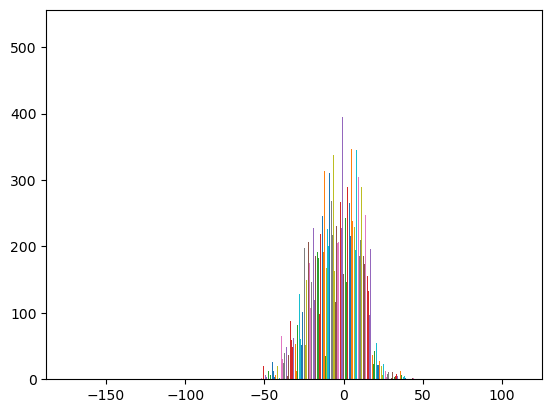

In [88]:
%%time

f,ax = plt.subplots()
ax.hist(tree_residual,bins=100)

## Todo
* Create a function to return values pretaining to a given landcover class
* Create a function which loops through the different landcover class in the Worldcover map, returning the values from above and plotting as histogram with different colors and light shading
* In the labels, plot the median and nmad for each class